# DSC550-T301 Data Mining
## 4.2 Exercise: Predicting Fuel Efficiency
### Daniel Solis Toro

## 1. Data Loading & Understanding

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('auto-mpg.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (398, 9)

First few rows:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  

Data types:
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: ob

## 2. Data Preprocessing

In [115]:
# Step 2.1: Remove car name column
df = df.drop('car name', axis=1)
print("Columns after removal:", df.columns.tolist())

# Step 2.2: Fix horsepower column
# Convert to numeric, forcing errors to NaN
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Calculate mean and fill NaN values
hp_mean = df['horsepower'].mean()
df['horsepower'] = df['horsepower'].fillna(hp_mean)
print(f"\nHorsepower mean used for filling: {hp_mean:.2f}")
print(f"Missing values after cleaning: {df['horsepower'].isnull().sum()}")

# Step 2.3: Create dummy variables for origin
# Check current values
print("\nOrigin column values:", df['origin'].unique())

# Create dummies (one-hot encoding)
df = pd.get_dummies(df, columns=['origin'], prefix='origin', drop_first=True)
print("\nColumns after creating dummies:", df.columns.tolist())

Columns after removal: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

Horsepower mean used for filling: 104.47
Missing values after cleaning: 0

Origin column values: [1 3 2]

Columns after creating dummies: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin_2', 'origin_3']


### Horsepower column values imported as a string data type

The horsepower column contains '?' values representing missing data. These cause pandas to interpret the entire column as strings (object dtype).
I converted these to NaN and filled them with the column mean (104.47).

## 3. Correlation coefficient matrix and visualization

Correlation with MPG:
mpg             1.000000
model year      0.579267
origin_3        0.442174
acceleration    0.420289
origin_2        0.259022
horsepower     -0.771437
cylinders      -0.775396
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64


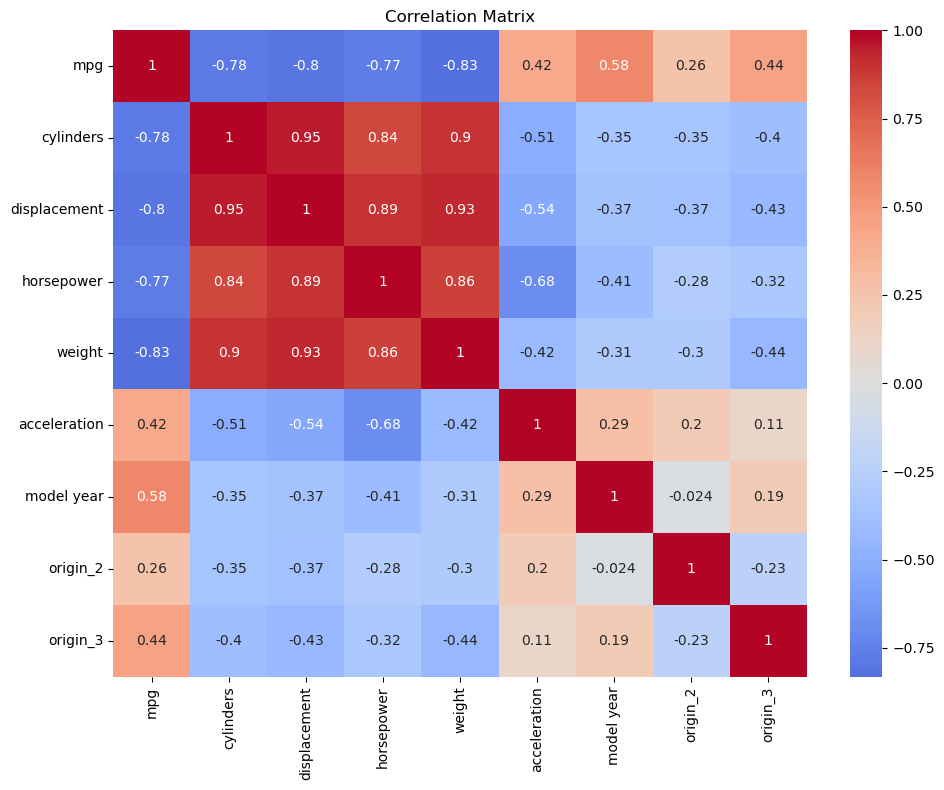

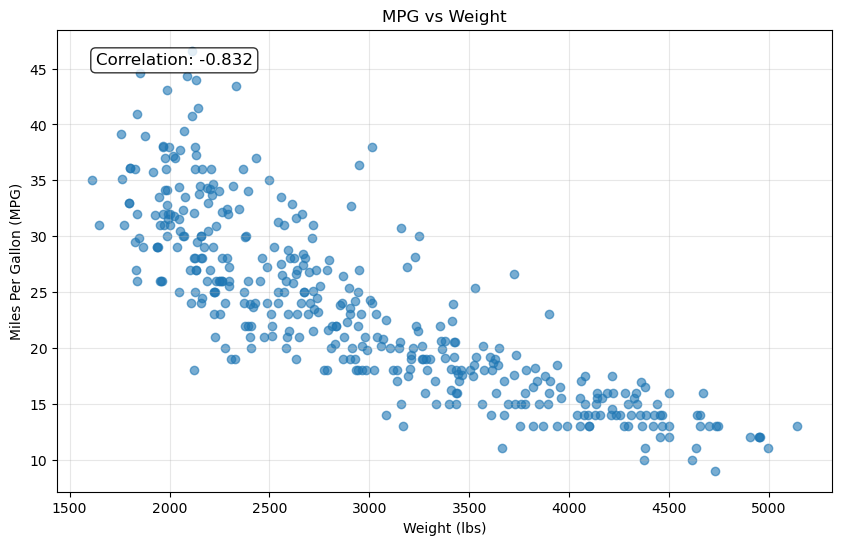

In [118]:
# Step 3.1: Correlation analysis
correlation_matrix = df.corr()
mpg_correlations = correlation_matrix['mpg'].sort_values(ascending=False)

print("Correlation with MPG:")
print(mpg_correlations)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Step 3.2: MPG vs Weight scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['weight'], df['mpg'], alpha=0.6)
plt.xlabel('Weight (lbs)')
plt.ylabel('Miles Per Gallon (MPG)')
plt.title('MPG vs Weight')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
corr_coef = np.corrcoef(df['weight'], df['mpg'])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

### Positive Correlations with MPG:
- Model year (0.579): Newer cars tend to have better fuel efficiency
- Origin_3 (0.442): Cars from origin 3 are more fuel-efficient
- Acceleration (0.420): Counterintuitive - faster acceleration correlates with better MPG

### Negative Correlations with MPG:
- Weight (-0.832): Strongest correlation - heavier cars have worse fuel efficiency
- Displacement (-0.804): Larger engines consume more fuel
- Cylinders (-0.775): More cylinders = lower MPG
- Horsepower (-0.771): More powerful engines are less efficient

## 4. Data Preparation

In [121]:
# Step 4: Split data into features (X) and target (y)
x = df.drop('mpg', axis=1)
y = df['mpg']

# Split into training (80%) and test (20%) sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print(f"Training set size: {x_train.shape}")
print(f"Test set size: {x_test.shape}")
print(f"\nTarget variable (MPG) statistics:")
print(f"Training mean: {y_train.mean():.2f}")
print(f"Test mean: {y_test.mean():.2f}")

Training set size: (318, 8)
Test set size: (80, 8)

Target variable (MPG) statistics:
Training mean: 23.61
Test mean: 23.14


## 5. Model training and Evaluation

In [123]:
# Step 5.1: Train Linear Regression
print("="*50)
print("LINEAR REGRESSION MODEL")
print("="*50)

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Function to calculate and print metrics
def evaluate_model(model, x_train, x_test, y_train, y_test, model_name):
    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate metrics
    metrics = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    print(f"\n{model_name} Performance:")
    print(f"R² Score - Train: {metrics['Train R2']:.4f}, Test: {metrics['Test R2']:.4f}")
    print(f"RMSE - Train: {metrics['Train RMSE']:.4f}, Test: {metrics['Test RMSE']:.4f}")
    print(f"MAE - Train: {metrics['Train MAE']:.4f}, Test: {metrics['Test MAE']:.4f}")
    
    # Interpretation
    print(f"\nInterpretation:")
    print(f"1. R² of {metrics['Test R2']:.4f} means the model explains "
          f"{metrics['Test R2']*100:.1f}% of variance in test data")
    print(f"2. On average, predictions are off by {metrics['Test MAE']:.2f} MPG (MAE)")
    print(f"3. RMSE of {metrics['Test RMSE']:.2f} gives more weight to larger errors")
    
    # Check for overfitting
    r2_diff = metrics['Train R2'] - metrics['Test R2']
    if r2_diff > 0.1:
        print(f"4. Warning: Potential overfitting (Train R² {r2_diff:.3f} higher than Test)")
    else:
        print(f"4. Good generalization (Train and Test R² are close)")
    
    return metrics

# Evaluate Linear Regression
lr_metrics = evaluate_model(lr_model, x_train, x_test, y_train, y_test, "Linear Regression")

# Step 5.2: Feature importance analysis for linear regression
print("\nLinear Regression Coefficients:")
for feature, coef in zip(x.columns, lr_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {lr_model.intercept_:.4f}")

LINEAR REGRESSION MODEL

Linear Regression Performance:
R² Score - Train: 0.8188, Test: 0.8449
RMSE - Train: 3.3703, Test: 2.8878
MAE - Train: 2.6055, Test: 2.2876

Interpretation:
1. R² of 0.8449 means the model explains 84.5% of variance in test data
2. On average, predictions are off by 2.29 MPG (MAE)
3. RMSE of 2.89 gives more weight to larger errors
4. Good generalization (Train and Test R² are close)

Linear Regression Coefficients:
cylinders: -0.1637
displacement: 0.0196
horsepower: -0.0133
weight: -0.0071
acceleration: 0.0734
model year: 0.8274
origin_2: 2.9392
origin_3: 2.6529
Intercept: -22.0667


## 6. Alternative Model (Ridge Regression)

In [125]:
# Step 6: Try Ridge Regression (regularized linear regression)
from sklearn.linear_model import Ridge

print("\n" + "="*50)
print("RIDGE REGRESSION MODEL")
print("="*50)

# Initialize and train Ridge regression
ridge_model = Ridge(alpha=1.0)  # alpha is regularization strength
ridge_model.fit(X_train, y_train)

# Evaluate Ridge Regression
ridge_metrics = evaluate_model(ridge_model, X_train, X_test, y_train, y_test, "Ridge Regression")

# Compare models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"{'Metric':<15} {'Linear Regression':<20} {'Ridge Regression':<20}")
print("-" * 55)
for metric in ['Test R2', 'Test RMSE', 'Test MAE']:
    print(f"{metric:<15} {lr_metrics[metric]:<20.4f} {ridge_metrics[metric]:<20.4f}")


RIDGE REGRESSION MODEL

Ridge Regression Performance:
R² Score - Train: 0.8188, Test: 0.8448
RMSE - Train: 3.3706, Test: 2.8889
MAE - Train: 2.6047, Test: 2.2916

Interpretation:
1. R² of 0.8448 means the model explains 84.5% of variance in test data
2. On average, predictions are off by 2.29 MPG (MAE)
3. RMSE of 2.89 gives more weight to larger errors
4. Good generalization (Train and Test R² are close)

MODEL COMPARISON
Metric          Linear Regression    Ridge Regression    
-------------------------------------------------------
Test R2         0.8449               0.8448              
Test RMSE       2.8878               2.8889              
Test MAE        2.2876               2.2916              


## 7. Visualization of Results

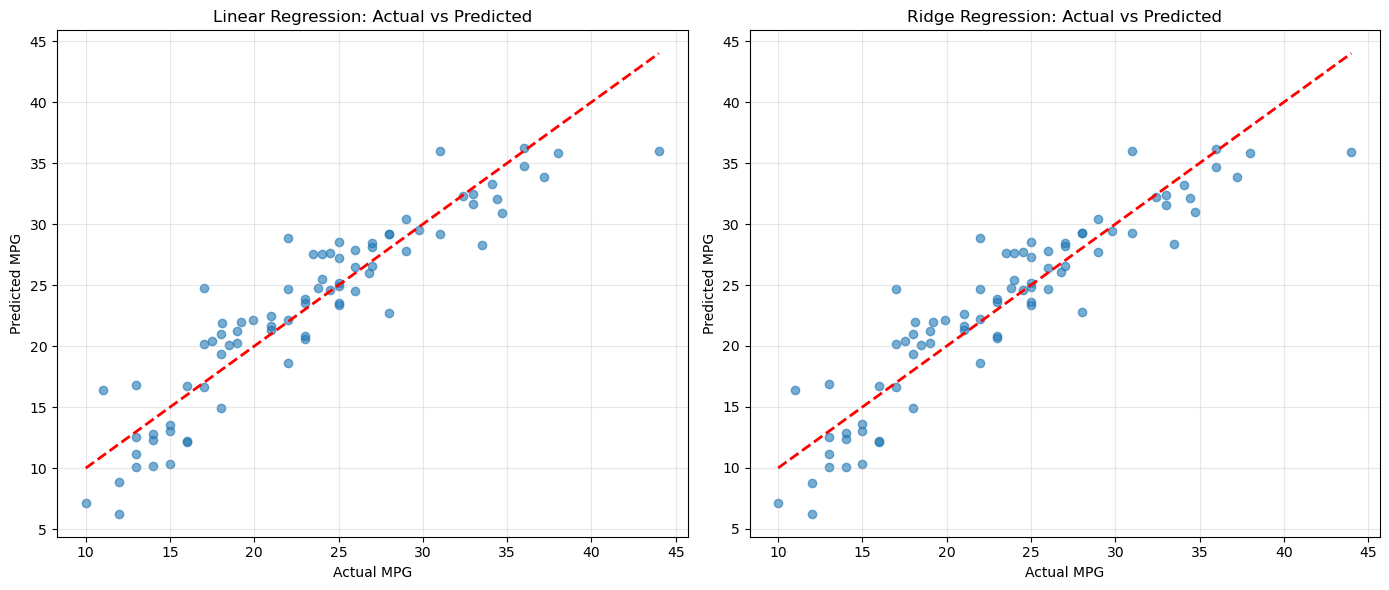

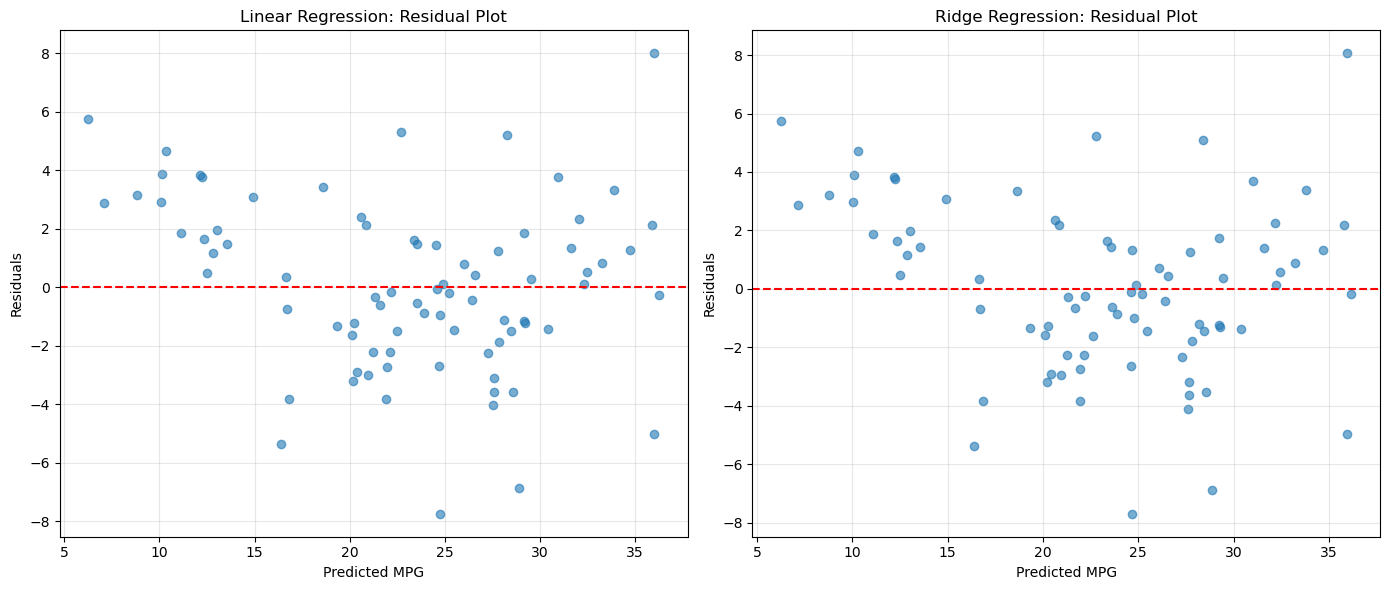

In [127]:
# Create actual vs predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression predictions
y_test_pred_lr = lr_model.predict(X_test)
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MPG')
axes[0].set_ylabel('Predicted MPG')
axes[0].set_title('Linear Regression: Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Ridge Regression predictions
y_test_pred_ridge = ridge_model.predict(X_test)
axes[1].scatter(y_test, y_test_pred_ridge, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual MPG')
axes[1].set_ylabel('Predicted MPG')
axes[1].set_title('Ridge Regression: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

residuals_lr = y_test - y_test_pred_lr
axes[0].scatter(y_test_pred_lr, residuals_lr, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted MPG')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression: Residual Plot')
axes[0].grid(True, alpha=0.3)

residuals_ridge = y_test - y_test_pred_ridge
axes[1].scatter(y_test_pred_ridge, residuals_ridge, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted MPG')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Ridge Regression: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()